In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


In [2]:
# Load dataset
df = pd.read_csv('crop data.csv')

# Create mappings for categorical data
location_dict = dict(enumerate(df['Location'].astype('category').cat.categories))
soil_dict = dict(enumerate(df['Soil'].astype('category').cat.categories))
irrigation_dict = dict(enumerate(df['Irrigation'].astype('category').cat.categories))
crop_dict = dict(enumerate(df['crop'].astype('category').cat.categories))

location_dict_reverse = {v: k for k, v in location_dict.items()}
soil_dict_reverse = {v: k for k, v in soil_dict.items()}
irrigation_dict_reverse = {v: k for k, v in irrigation_dict.items()}
crop_dict_reverse = {v: k for k, v in crop_dict.items()}

In [3]:
# Data Preprocessing and Outlier Handling
df['Location'] = df['Location'].astype('category').cat.codes
df['Soil'] = df['Soil'].astype('category').cat.codes
df['Irrigation'] = df['Irrigation'].astype('category').cat.codes
df['crop'] = df['crop'].astype('category').cat.codes

In [4]:
# Outlier detection and removal (using Z-score method)
z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))
df = df[(z_scores < 3).all(axis=1)]

# Define features and target variable
X = df.drop(columns=['Price'])
y = df['Price']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X_train, y_train)
feature_scores = pd.DataFrame({
    'Feature': df.drop(columns=['Price']).columns,
    'Score': selector.scores_
}).sort_values(by='Score', ascending=False)

print("Feature Ranking:")
print(feature_scores)

Feature Ranking:
        Feature       Score
9          crop  711.823058
7        Yeilds  318.477374
0          Year   73.593584
1      Location   35.807588
3      Rainfall   31.109153
10       Demand   26.156412
2          Area    3.202560
6    Irrigation    3.196722
4          Soil    1.699997
5   temperature    0.459611
8      Humidity    0.027054


In [6]:
# Model Selection with Cross-Validation and Hyperparameter Tuning
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Multiple Linear Regression': LinearRegression(),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'Support Vector Machine': SVR(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42),
    
}

# Hyperparameter grids for models
param_grids = {
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
    'Ridge Regression': {'alpha': [0.1, 1.0, 10.0]},
    'Lasso Regression': {'alpha': [0.01, 0.1, 1.0]},
    'K-Nearest Neighbors': {'n_neighbors': [3, 5, 7, 10]},
    'Support Vector Machine': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'Decision Tree': {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]},
    'XGBoost': {'n_estimators': [50, 100, 200], 'max_depth': [3, 6, 10], 'learning_rate': [0.01, 0.1, 0.2]},
    
}

# Evaluation dictionaries
mse_scores = {}
mae_scores = {}
r2_scores = {}
best_models = {}

# Train and evaluate models
for name, model in models.items():
    print(f"Tuning {name}...")
    if name in param_grids:
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='r2')
        grid_search.fit(X_train, y_train)
        best_models[name] = grid_search.best_estimator_
        print(f"Best parameters for {name}: {grid_search.best_params_}")
    else:
        model.fit(X_train, y_train)
        best_models[name] = model

    # Evaluate model
    y_pred = best_models[name].predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mse_scores[name] = mse
    mae_scores[name] = mae
    r2_scores[name] = r2

    print(f"{name} - MSE: {mse:.2f}, MAE: {mae:.2f}, R² Score: {r2:.2f}")

Tuning Random Forest...
Best parameters for Random Forest: {'max_depth': 20, 'n_estimators': 100}
Random Forest - MSE: 1.57, MAE: 0.46, R² Score: 1.00
Tuning Gradient Boosting...
Best parameters for Gradient Boosting: {'learning_rate': 0.2, 'n_estimators': 200}
Gradient Boosting - MSE: 0.71, MAE: 0.49, R² Score: 1.00
Tuning Ridge Regression...
Best parameters for Ridge Regression: {'alpha': 10.0}
Ridge Regression - MSE: 441.66, MAE: 14.38, R² Score: 0.43
Tuning Lasso Regression...
Best parameters for Lasso Regression: {'alpha': 0.1}
Lasso Regression - MSE: 441.48, MAE: 14.37, R² Score: 0.43
Tuning Multiple Linear Regression...
Multiple Linear Regression - MSE: 441.83, MAE: 14.39, R² Score: 0.43
Tuning K-Nearest Neighbors...
Best parameters for K-Nearest Neighbors: {'n_neighbors': 3}
K-Nearest Neighbors - MSE: 202.56, MAE: 7.31, R² Score: 0.74
Tuning Support Vector Machine...
Best parameters for Support Vector Machine: {'C': 10, 'kernel': 'rbf'}
Support Vector Machine - MSE: 313.57, MAE

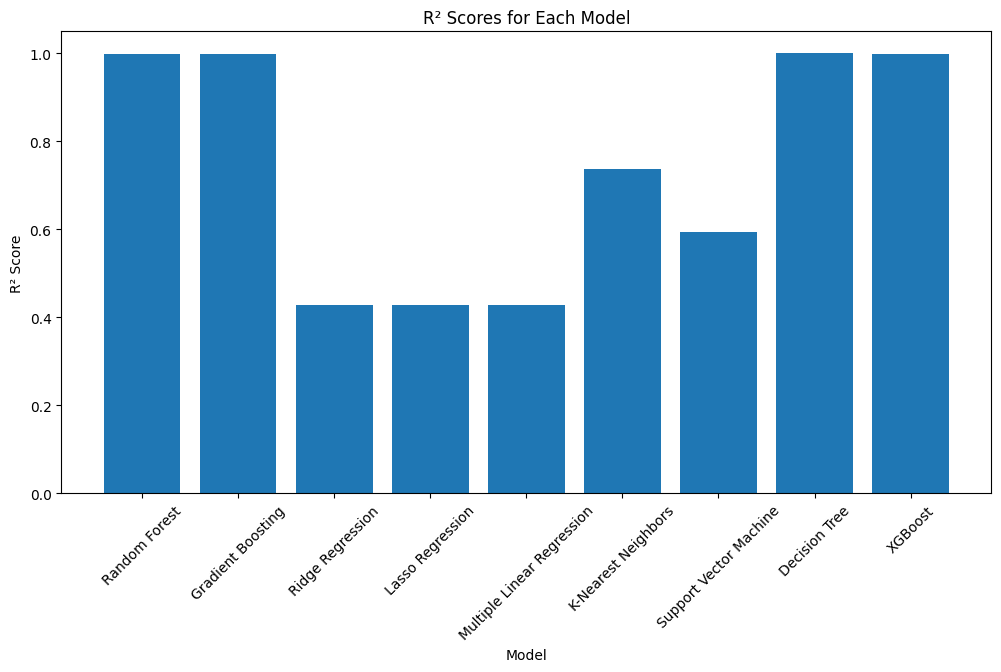

In [7]:
# Plotting R² Scores for all models
plt.figure(figsize=(12, 6))
plt.bar(r2_scores.keys(), r2_scores.values())
plt.title("R² Scores for Each Model")
plt.xlabel("Model")
plt.ylabel("R² Score")
plt.xticks(rotation=45)
plt.show()

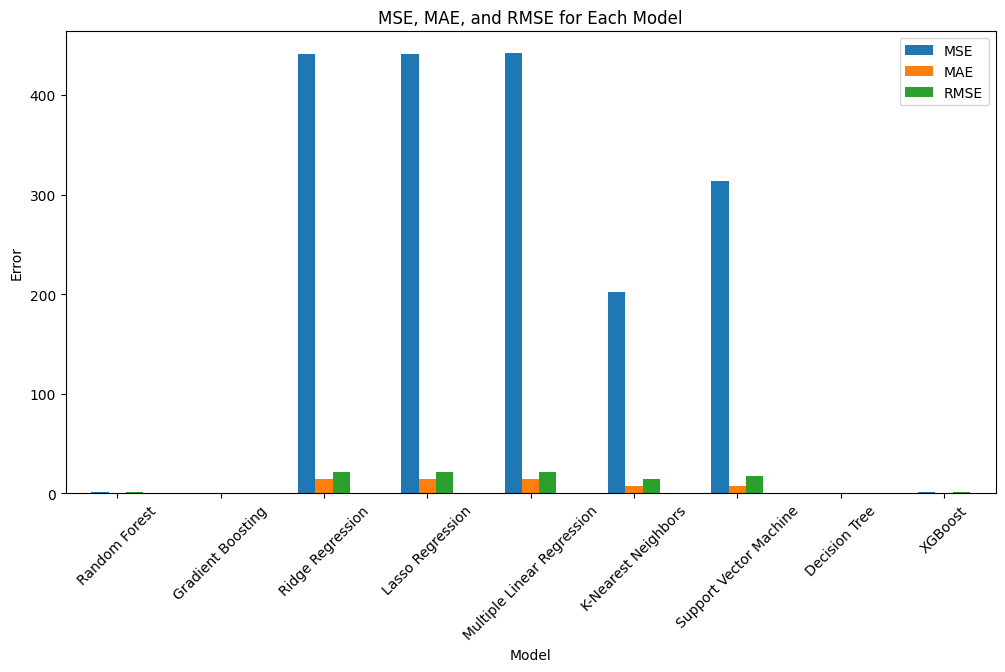

In [8]:
# Plotting MSE, MAE, and RMSE for all models
metrics_df = pd.DataFrame({
    'Model': list(mse_scores.keys()),
    'MSE': list(mse_scores.values()),
    'MAE': list(mae_scores.values()),
    'RMSE': [np.sqrt(mse) for mse in mse_scores.values()]
})

metrics_df.set_index('Model').plot(kind='bar', figsize=(12, 6))
plt.title("MSE, MAE, and RMSE for Each Model")
plt.ylabel("Error")
plt.xticks(rotation=45)
plt.show()

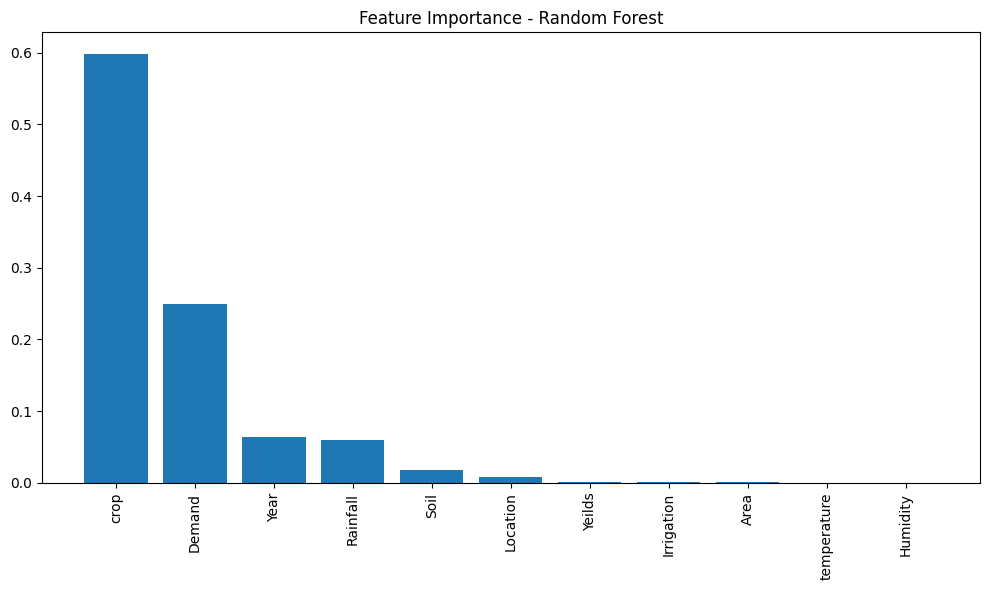

In [9]:
# Feature Importance for Tree-Based Models
if 'Random Forest' in best_models:
    rf_model = best_models['Random Forest']
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    features = df.drop(columns=['Price']).columns

    plt.figure(figsize=(10, 6))
    plt.title("Feature Importance - Random Forest")
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

Random Forest - Mean Squared Error: 1.57, R2 Score: 1.00
Gradient Boosting - Mean Squared Error: 0.71, R2 Score: 1.00
Ridge Regression - Mean Squared Error: 441.66, R2 Score: 0.43
Lasso Regression - Mean Squared Error: 441.48, R2 Score: 0.43
Multiple Linear Regression - Mean Squared Error: 441.83, R2 Score: 0.43
K-Nearest Neighbors - Mean Squared Error: 202.56, R2 Score: 0.74
Support Vector Machine - Mean Squared Error: 313.57, R2 Score: 0.59
Decision Tree - Mean Squared Error: 0.46, R2 Score: 1.00
XGBoost - Mean Squared Error: 1.08, R2 Score: 1.00


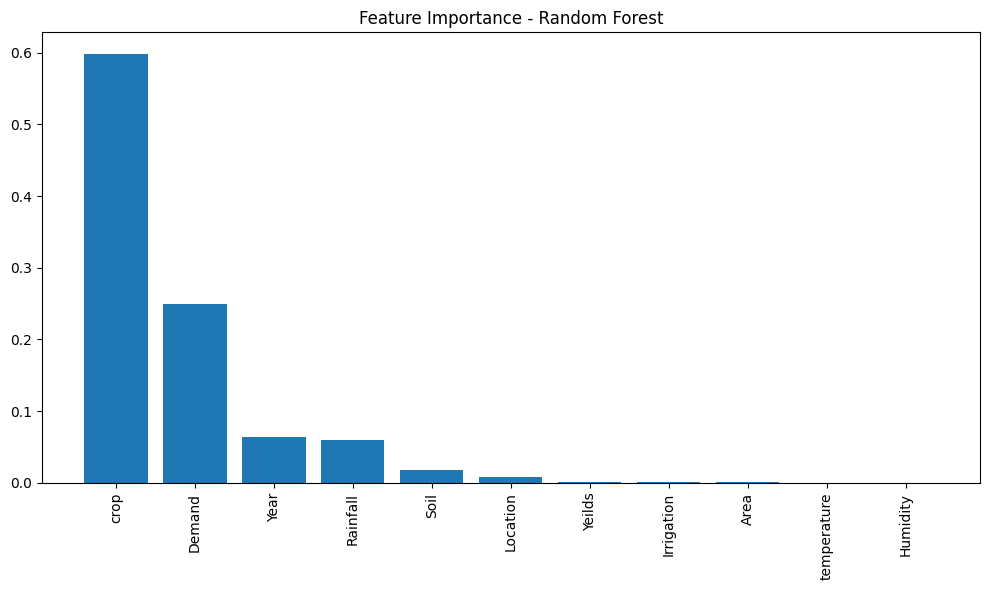

In [10]:
# Evaluation of Best Models
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - Mean Squared Error: {mse:.2f}, R2 Score: {r2:.2f}")

# Feature Importance for Tree-Based Models
if 'Random Forest' in best_models:
    rf_model = best_models['Random Forest']
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    features = df.drop(columns=['Price']).columns

    # Plotting Feature Importance
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importance - Random Forest")
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

In [15]:
# Function to gather user input and predict crop price
def predict_crop_price():
    location_input = input("Enter Location: ")
    soil_input = input("Enter Soil type: ")
    irrigation_input = input("Enter Irrigation type: ")
    crop_input = input("Enter Crop type: ")

    # Convert string inputs to numerical codes using reverse mappings
    location_code = location_dict_reverse.get(location_input, 2)
    soil_code = soil_dict_reverse.get(soil_input, 2)
    irrigation_code = irrigation_dict_reverse.get(irrigation_input, 2)
    crop_code = crop_dict_reverse.get(crop_input, 2)

    # Gather numerical inputs
    year = int(input("Enter Year: "))
    area = int(input("Enter Area: "))
    rainfall = int(input("Enter Rainfall: "))
    temperature = int(input("Enter Temperature: "))
    yeilds = float(input("Enter Yields: "))
    humidity = int(input("Enter Humidity: "))
    demand = float(input("Enter Demand: "))

    # Create a DataFrame for input
    input_data = pd.DataFrame({
        'Year': [year],
        'Location': [location_code],
        'Area': [area],
        'Rainfall': [rainfall],
        'Soil': [soil_code],
        'temperature': [temperature],
        'Irrigation': [irrigation_code],
        'Yeilds': [yeilds],
        'Humidity': [humidity],
        'crop': [crop_code],
        'Demand': [demand]
    })

    # Scale input data
    input_data_scaled = scaler.transform(input_data)

    # Predict crop price using the best model (e.g., Random Forest)
    prediction = best_models['Random Forest'].predict(input_data_scaled)
    print(f"Predicted Crop Price: {prediction[0]:.2f}")

# Run prediction function
predict_crop_price()

Predicted Crop Price: 24.27
